In [24]:
from scipy.io import loadmat

folder = "/Volumes/LACIE SHARE/seizure-prediction"

mat_data = loadmat(folder + "/Dog_1/Dog_1/Dog_1_interictal_segment_0001.mat")
print(mat_data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 21 01:00:00 2014', '__version__': '1.0', '__globals__': [], 'interictal_segment_1': array([[(array([[  0,  13,  15, ..., -25, -21, -12],
               [-26,  -4,  11, ..., -39, -32, -21],
               [-42, -35, -19, ..., -16, -16, -18],
               ...,
               [ 45,  30,  25, ...,  43,  28,  17],
               [ 15,   8,  -6, ...,  14,  13,   6],
               [-18, -20, -19, ...,   9,   9,   3]], dtype=int16), array([[600]], dtype=uint16), array([[399.6097561]]), array([[array(['NVC1202_32_002_Ecog_c001'], dtype='<U24'),
                array(['NVC1202_32_002_Ecog_c002'], dtype='<U24'),
                array(['NVC1202_32_002_Ecog_c003'], dtype='<U24'),
                array(['NVC1202_32_002_Ecog_c004'], dtype='<U24'),
                array(['NVC1202_32_002_Ecog_c005'], dtype='<U24'),
                array(['NVC1202_32_002_Ecog_c006'], dtype='<U24'),
                array(['NVC1202_32_002_Ecog_

In [ ]:
import numpy as np
signals = np.array(mat_data['interictal_segment_1'][0, 0][0])
print(signals)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Pxx, freqs, bins, im = plt.specgram(signals[0, :], Fs=400)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

t_axis = np.arange(0, signals.shape[1])*(1/400)
plt.plot(t_axis, signals[0, :])
plt.show()

fft_0 = np.fft.fft(signals[0,:])
plt.plot(fft_0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
from sklearn.decomposition import FastICA

number_of_components = 16

# Perform ICA on the EEG data
ica = FastICA(n_components=number_of_components)  # Set the desired number of components
ica_components = ica.fit_transform(signals)  # Transpose data for ICA

# Plot original EEG data and ICA components for visualization
num_plots = min(number_of_components, 10)  # Adjust the number of plots based on components
plt.figure(figsize=(10, 6))

# Plot original EEG data (plotting the first channel as an example)
plt.subplot(num_plots + 1, 1, 1)
plt.plot(signals[0, :])  # Plotting the first channel as an example

# Plot ICA components
for i in range(num_plots):
    plt.subplot(num_plots + 1, 1, i + 2)
    plt.plot(ica_components[:, i])

plt.tight_layout()
plt.show()

## Define custom features

In [ ]:
from tsfresh.feature_extraction.feature_calculators import abs_energy
from tsfresh.feature_extraction import extract_features
import numpy as np
import pandas as pd

Fs = 399.6097561  # Hz


def root_abs_energy(x):
    return np.sqrt(abs_energy(x))


def get_powers(x):
    freq = np.fft.fftfreq(x.shape[0], d=1/Fs)
    power_spectrum = np.abs(np.fft.fft(x))**2
    results = {}
    results['power_delta'] = np.mean(power_spectrum[(freq >= 1) & (freq < 4)])
    results['power_theta'] = np.mean(power_spectrum[(freq >= 4) & (freq < 8)])
    results['power_alpha'] = np.mean(power_spectrum[(freq >= 8) & (freq < 14)])
    results['power_beta'] = np.mean(power_spectrum[(freq >= 14) & (freq < 30)])
    results['power_gamma'] = np.mean(power_spectrum[(freq >= 30)])
    return results


def get_custom_feat(x):
    results = get_powers(x)
    results['root_abs_energy'] = np.sqrt(abs_energy(x))
    return results
    

fc_parameters = {
    "mean": None,
    "standard_deviation": None,
    "absolute_sum_of_changes": None,
    "minimum": None,
    "maximum": None,
    "skewness": None,
    "kurtosis": None,
    "root_mean_square": None
}

test_df = pd.DataFrame({'id': 0, 'signal': signals[0,:]})
print(signals[0,:])
print(test_df.head())

ts_results = extract_features(test_df, default_fc_parameters=fc_parameters, column_id='id', n_jobs=5)
cust_results = get_custom_feat(signals[0,:])
print(cust_results)
all_feat = pd.concat([ts_results, pd.DataFrame(cust_results, index=[0])], axis=1)
print(all_feat)

In [ ]:
import pandas as pd
import numpy as np

upper_time = 1200  # s, (20 min)

def segment_signal(signal, window_size, overlap, Fs):
    window_id = 0
    window_start_ind = 0
    signal_length = signal.shape[0]
    t_axis = np.arange(0, signal_length*Fs, 1/Fs)
    result_df = pd.DataFrame(columns=["window_id", "time", "signal"])
    while window_start_ind < signal_length:
        window_end_ind = np.min([signal_length, window_start_ind+window_size])
        
        this_time = upper_time * np.ones((window_size,))
        this_signal = np.zeros((window_size,))
        this_time[:window_end_ind-window_start_ind] = t_axis[window_start_ind:window_end_ind]
        this_signal[:window_end_ind-window_start_ind] = signal[window_start_ind:window_end_ind]

        this_df = pd.DataFrame({"window_id": window_id, "time": this_time, "signal": this_signal})
        result_df = pd.concat([result_df, this_df])
        
        window_start_ind += window_size - overlap
        window_id += 1
    return result_df


result_df = segment_signal(signals[0, 0:3600], 800, 200, Fs)
print(result_df[result_df['window_id'] == 5])
ts_fresh_feat = extract_features(result_df, default_fc_parameters=fc_parameters, column_id='window_id', column_sort='time', n_jobs=5)
print(ts_fresh_feat)

In [ ]:
def extract_feat_per_window(window_df, sample_col='window_id'):
    ts_fresh_feat = extract_features(window_df, default_fc_parameters=fc_parameters, column_id='window_id', column_sort='time', n_jobs=5)
    cust_results = []
    for i in range(window_df[sample_col].max()+1):
        this_sig = window_df[window_df[sample_col] == i]
        this_sig = this_sig['signal'].to_numpy()
        cust_results.append(get_custom_feat(this_sig))
    all_feat = pd.concat([ts_fresh_feat, pd.DataFrame(cust_results)], axis=1)
    return all_feat

all_feat = extract_feat_per_window(result_df)
print(all_feat)

## Data splitting

In [ ]:
import os

root_folder = "/Volumes/LACIE SHARE/seizure-prediction"
sub_folders = ["Dog_1/Dog_1", "Dog_2/Dog_2", "Dog_3/Dog_3", "Dog_4/Dog_4", "Dog_5/Dog_5"]
interictal_files = []
preictal_files = []
test_files = []
for fol in sub_folders:
    for file_name in os.listdir(os.path.join(root_folder, fol)):
        if "._" in file_name:
            continue
        if 'interictal' in file_name:
            interictal_files.append(os.path.join(fol, file_name))
        elif 'preictal' in file_name:
            preictal_files.append(os.path.join(fol, file_name))
        elif 'test' in file_name:
            test_files.append(os.path.join(fol, file_name))

# save results
with open('interictal.txt', 'w') as f:
    for file_name in interictal_files:
        f.write(file_name + "\n")
with open('preictal.txt', 'w') as f:
    for file_name in preictal_files:
        f.write(file_name + "\n")
with open('nolabel.txt', 'w') as f:
    for file_name in test_files:
        f.write(file_name + "\n")

In [ ]:
from sklearn.model_selection import train_test_split

interictal_files = [file_name.strip() for file_name in open('interictal.txt').readlines()]
preictal_files = [file_name.strip() for file_name in open('preictal.txt').readlines()]
all_files = interictal_files + preictal_files
classes = np.ones((len(all_files),))
classes[:len(interictal_files)] = 0

train_files, test_files = train_test_split(all_files, test_size=0.3, random_state=23, stratify=classes)

# save results
with open('train.txt', 'w') as f:
    for file_name in train_files:
        f.write(file_name + "\n")
with open('test.txt', 'w') as f:
    for file_name in test_files:
        f.write(file_name + "\n")      

### Undersample training set

In [ ]:
train_files = open("./data/train.txt").readlines()
train_preictal = [filename for filename in train_files if "preictal" in filename]
train_interictal = [filename for filename in train_files if "interictal" in filename]
print(f"Number of preictal training samples: {len(train_preictal)}")
print(f"Number of interictal training samples: {len(train_interictal)}")

# should only run code below once and then used saved file list going forward

# num_preictal = len(train_preictal)
# train_undersamp_interictal = np.random.choice(train_interictal, num_preictal, replace=False)
# train_files_sampled = train_preictal + train_undersamp_interictal.tolist()

# # save results
# with open('./data/train_undersampled.txt', 'w') as f:
#     for file_name in train_files_sampled:
#         f.write(file_name.strip() + "\n")

## Extract features for undersampled training set

In [1]:
import numpy as np

def segment_signal_multichannel(signals, window_size, overlap, Fs, window_id_start=0, window_start_ind=0):
    """ expects signals to be number of channels x number of eeg samples
    """
    window_id = window_id_start
    window_start_ind = window_start_ind
    num_channels = signals.shape[0]
    signal_length = signals.shape[1]
    t_axis = np.arange(0, signal_length*Fs, 1/Fs)
    upper_time = 1200  # 20 min
    signal_cols = ["channel_" + str(i) for i in range(num_channels)]
    result_df = pd.DataFrame(columns=["window_id", "time"] + signal_cols)
    signals = np.transpose(signals)
    while window_start_ind < signal_length:
        window_end_ind = np.min([signal_length, window_start_ind+window_size])
        
        this_time = upper_time * np.ones((window_size,))
        this_signal = np.zeros((window_size, num_channels))
        this_time[:window_end_ind-window_start_ind] = t_axis[window_start_ind:window_end_ind]
        this_signal[:window_end_ind-window_start_ind, :] = signals[window_start_ind:window_end_ind, :]

        this_df = pd.DataFrame({"window_id": window_id, "time": this_time})
        for i, channel_name in enumerate(signal_cols):
            this_df[channel_name] = this_signal[:, i]
        result_df = pd.concat([result_df, this_df])
        
        window_start_ind += window_size - overlap
        window_id += 1
    return result_df

In [2]:
from scipy.io import loadmat
import os
import numpy as np
import pandas as pd

Fs = 399.6097561
window_size = 1200  # 3s
window_overlap = 400  # 1s
processing_chunk_num_windows = 5

def get_data_key_from_filename(filename):
    filename = filename.split("/")
    filename = filename[-1].split(".")
    filename = filename[0].split("_")
    filename = filename[2:]
    filename[-1] = filename[-1].lstrip("0")
    return "_".join(filename)


root_folder = "/Volumes/LACIE SHARE/seizure-prediction"
output_folder = "/Volumes/LACIE SHARE/seizure-prediction-outputs/windows_3sduration_1soverlap"
train_files_undersamp = [f.strip() for f in open("./data/train_undersampled.txt").readlines()]
for i, filename in enumerate(train_files_undersamp):
    print(f"Segmenting file {i}/{len(train_files_undersamp)}: {filename.split('/')[-1]}")
    filepath = os.path.join(root_folder, filename)
    mat_data = loadmat(filepath)
    signals = np.array(mat_data[get_data_key_from_filename(filename)][0, 0][0])
    outfilename = filename.split("/")[-1]
    outfilename = outfilename.split(".")[0] + ".csv"
    outpath = os.path.join(output_folder, outfilename)
    
    window_start_ind = 0
    window_end_ind = window_size + (window_size - window_overlap)*(processing_chunk_num_windows-1)
    window_id_start = 0
    while window_start_ind < signals.shape[1]:
        chunk_df = segment_signal_multichannel(signals[:,window_start_ind:window_end_ind], window_size, window_overlap, 
                                               Fs, window_id_start, window_start_ind)
        chunk_df.to_csv(outpath, index=False, mode='a')
        print(chunk_df.head())
        window_start_ind = window_end_ind-window_overlap
        print(window_start_ind)
        window_end_ind = window_start_ind + window_size + (window_size - window_overlap)*(processing_chunk_num_windows-1)
        print(window_end_ind)
        window_id_start += processing_chunk_num_windows
    
    break
print("Done")

Segmenting file 0/370: Dog_4_preictal_segment_0017.mat
  window_id      time  channel_0  channel_1  channel_2  channel_3  channel_4  \
0         0  0.000000      -50.0       58.0       43.0      -28.0      -32.0   
1         0  0.002502      -45.0       51.0       51.0       -5.0      -55.0   
2         0  0.005005      -36.0       58.0       66.0       12.0      -75.0   
3         0  0.007507      -14.0       71.0       75.0       30.0      -71.0   
4         0  0.010010        2.0       83.0       78.0       44.0      -67.0   

   channel_5  channel_6  channel_7  channel_8  channel_9  channel_10  \
0        6.0       17.0       -2.0       35.0      -40.0       -73.0   
1      -11.0       -4.0        4.0       43.0      -12.0       -61.0   
2      -30.0      -33.0        9.0       51.0        1.0       -56.0   
3      -35.0      -34.0        2.0       43.0        0.0       -62.0   
4      -37.0      -23.0        4.0       32.0       -1.0       -67.0   

   channel_11  channel_12  chan

KeyboardInterrupt: 

### Explore spectrograms

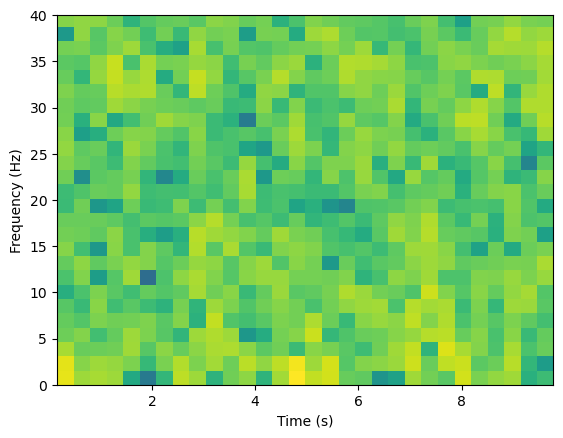

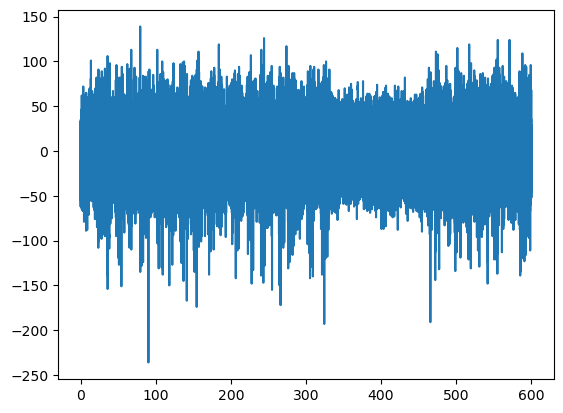

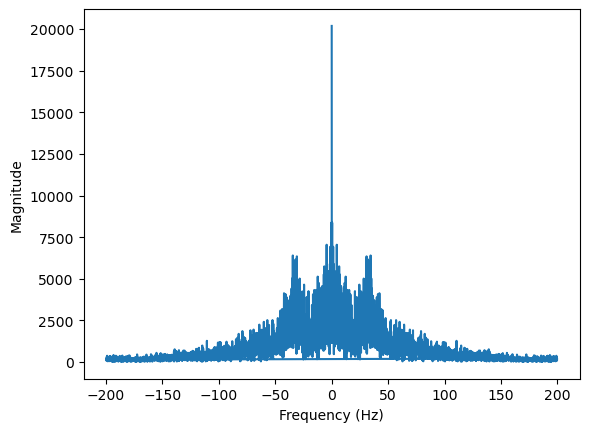

In [44]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os

Fs = 399.6097561

folder = "/Volumes/LACIE SHARE/seizure-prediction"

mat_data = loadmat(folder + "/Dog_1/Dog_1/Dog_1_preictal_segment_0003.mat")
signals = np.array(mat_data['preictal_segment_3'][0, 0][0])

# Pxx, freqs, bins, im = plt.specgram(signals[0, :], Fs=Fs)
Pxx, freqs, bins, im = plt.specgram(signals[0, 0:4000], Fs=Fs)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
ax = plt.gca()
ax.set_ylim(0, 40)
plt.show()

t_axis = np.arange(0, signals.shape[1])*(1/Fs)
plt.plot(t_axis, signals[0, :])
plt.show()

# fft_0 = np.abs(np.fft.fft(signals[0, :]))
# fft_x = np.fft.fftfreq(signals.shape[1], d=1/Fs)
fft_0 = np.abs(np.fft.fft(signals[0, 0:4000]))
fft_x = np.fft.fftfreq(4000, d=1/Fs)
# plt.plot(fft_x[(fft_x >= 40) & (fft_x <= 70)], fft_0[(fft_x >= 40) & (fft_x <= 70)])
plt.plot(fft_x, fft_0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

## Load synthetic training data

In [1]:
import numpy as np
import os

train_files = [f.strip() for f in open("./data/train.txt").readlines()]
interictal_train_files = [f for f in train_files if "interictal" in f]
preictal_train_files = [f for f in train_files if "preictal" in f]
interictal_train_files = np.random.choice(interictal_train_files, len(preictal_train_files), replace=False)
train_undersamfiles = [f.strip() for f in open("./data/train.txt").readlines()]


185


In [7]:
test_files = [f.strip() for f in open("./data/test.txt").readlines()]
interictal_test_files = [f for f in test_files if "interictal" in f and "Dog_5" not in f]
preictal_test_files = [f for f in test_files if "preictal" in f and "Dog_5" not in f]
print(len(interictal_test_files))
print(len(preictal_test_files))
print(int(len(interictal_test_files)*2/3))
print(int(len(preictal_test_files)*2/3))
print(f"Number of 10s test windows, interictal: {int(len(interictal_test_files)*2/3)*59}")
print(f"Number of 10s test windows, preictal: {int(len(preictal_test_files)*2/3)*59}")

961
70
640
46
Number of 10s test windows, interictal: 37760
Number of 10s test windows, preictal: 2714
